# Task 4 (4.1, 4.2, 4.3, 4.4)

## Imports

In [1]:
from PIL import Image, ImageFilter, ImageOps
import numpy as np      # is ke ialwa ghar nahi chale ga
import matplotlib.pyplot as plt
import matplotlib
import cv2
import math    # small math helpers (ceil waghra)
import random           # reproducible shuffling
import copy          # deepcopy models for best chjkpnts
from copy import deepcopy
import os
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim     # optimizers
from torch.amp import autocast
from torch.utils.data import Subset, DataLoader, ConcatDataset     # batched loading
from torchvision import datasets, transforms, models  #datasets + aug
from torchvision.transforms import functional as TF   # low level transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import defaultdict, OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [47]:
matplotlib.rcParams.update({
    "figure.dpi": 100,
    "savefig.dpi": 600,
    "font.family": "DejaVu Serif",   # safe default
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.linewidth": 1.2
})

batch_size = 128
lr = 0.01
local_epochs = 5
roundss = 20
num_clients = 5
alpha = 0.1
rho = 0.05
mu = 0.1

## Dataset

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

100%|██████████| 170M/170M [00:02<00:00, 84.8MB/s] 


In [4]:
def dirichlet_split_noniid(train_dataset, alpha, num_clients, batch_size=batch_size, num_workers=2):
    """
    Splits a dataset into non-IID partitions using Dirichlet distribution.

    Args:
        train_dataset: full CIFAR-10 training dataset
        alpha: Dirichlet concentration parameter (smaller = more skewed)
        num_clients: number of FL clients
        batch_size: DataLoader batch size
        num_workers: for DataLoader

    Returns:
        client_loaders: list of DataLoader objects, one per client
    """

    labels = np.array(train_dataset.targets)
    num_classes = labels.max() + 1   # 10 for CIFAR-10

    # list of client -> list of indices
    client_indices = [[] for _ in range(num_clients)]

    # For each class, split its indices among clients using Dirichlet proportions
    for c in range(num_classes):
        class_indices = np.where(labels == c)[0]
        np.random.shuffle(class_indices)

        # Sample Dirichlet proportions
        # e.g., for 10 clients, this gives a vector summing to 1
        proportions = np.random.dirichlet([alpha] * num_clients)

        # Compute number of samples for each client
        proportions = (proportions / proportions.sum()) * len(class_indices)
        proportions = proportions.astype(int)

        # Fix mismatch due to int rounding
        diff = len(class_indices) - proportions.sum()
        proportions[0] += diff

        # Assign slices of class indices to each client
        start = 0
        for i in range(num_clients):
            cnt = proportions[i]
            client_indices[i].extend(class_indices[start:start+cnt])
            start += cnt

    # Build DataLoaders for each client
    client_loaders = []
    for i in range(num_clients):
        subset = Subset(train_dataset, client_indices[i])
        loader = DataLoader(subset, batch_size=batch_size, shuffle=True,
                            num_workers=num_workers, pin_memory=True)
        client_loaders.append(loader)

    return client_loaders


def print_class_distribution_from_loaders(client_loaders):
    """
    Prints class percentage distribution for each client directly from client_loaders.
    Assumes each loader.dataset is a Subset with .dataset.targets available
    (CIFAR-10, MNIST, etc.).
    """

    for cid, loader in enumerate(client_loaders):
        subset = loader.dataset

        # parent dataset
        parent = subset.dataset

        # indices for this client
        idxs = subset.indices

        # CIFAR labels live here
        labels = np.array(parent.targets)[idxs]

        num_classes = labels.max() + 1 if len(labels) > 0 else 0

        if len(labels) == 0:
            print(f"Client {cid}: [EMPTY]")
            continue

        counts = np.bincount(labels, minlength=num_classes)
        total = len(labels)

        percentages = counts / total * 100
        formatted = "[" + " ".join(f"{p:.1f}%" for p in percentages) + "]"

        print(f"Client {cid}: {formatted}")


## Base Model

In [5]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Conv blocks (kept small to hit ~100k params)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        # Reduced channels (96) to keep total params around 90k
        self.conv3 = nn.Conv2d(64, 96, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(96)

        self.pool = nn.MaxPool2d(2, 2)

        # After 3 pools: 32→16→8→4
        self.fc = nn.Linear(96 * 4 * 4, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def count_params(m):
    return sum(p.numel() for p in m.parameters())

model = SmallCNN().to(device)
print("params:", count_params(model))

params: 90538


In [6]:
def evaluate(model, loader, device=device):
    model.eval()
    correct = 0
    total = 0
    loss_fn = nn.CrossEntropyLoss()
    running_loss = 0.0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100.0 * correct / total
    avg_loss = running_loss / total
    return avg_loss, acc

## Normal SGD

In [7]:
def train_model(model, train_loader, test_loader, device=device,
                epochs=100, lr=0.01, weight_decay=0.0, print_every=1):
    """
    Trains the given model and reports train loss, train acc, test acc, and time per epoch.
    """
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        start_time = time.time()

        for imgs, labels in train_loader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100.0 * correct / total

        if test_loader is not None:
            test_loss, test_acc = evaluate(model, test_loader, device)
        else:
            test_loss, test_acc = None, None

        epoch_time = time.time() - start_time

        if epoch % print_every == 0:
            if test_loader is not None:
                print(f"Epoch {epoch}/{epochs} | "
                      f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
                      f"Test Acc: {test_acc:.2f}% | Time: {epoch_time:.2f}s")
            else:
                print(f"Epoch {epoch}/{epochs} | "
                      f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
                      f"Time: {epoch_time:.2f}s")

    return model

## Normal SAM

In [8]:
def train_model_sam(model, train_loader, test_loader, device,
                    epochs=10, lr=0.01, rho=rho, weight_decay=0.0, print_every=1):
    """
    Trains the model using SAM (Sharpness-Aware Minimization).
    rho: SAM neighborhood radius (usually small, e.g., 0.05 or 0.5*lr)
    """
    model = model.to(device)
    base_optimizer = optim.SGD  # can also use Adam
    optimizer = base_optimizer(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        start_time = time.time()

        for imgs, labels in train_loader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # --------- FIRST FORWARD/BACKWARD: ascent step ---------
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Save current parameters and compute perturbation
            grad_norm = torch.norm(torch.cat([p.grad.flatten() for p in model.parameters() if p.grad is not None]))
            scale = rho / (grad_norm + 1e-12)
            for p in model.parameters():
                if p.grad is not None:
                    p.data.add_(p.grad, alpha=scale)  # w_adv = w + ρ * grad / ||grad||

            # --------- SECOND FORWARD/BACKWARD: descent step ---------
            optimizer.zero_grad()
            outputs_adv = model(imgs)
            loss_adv = criterion(outputs_adv, labels)
            loss_adv.backward()

            # Restore original weights and do optimizer step
            for p in model.parameters():
                if p.grad is not None:
                    p.data.sub_(p.grad, alpha=scale)  # restore step (optional depending on implementation)

            optimizer.step()

            # Track training stats
            running_loss += loss_adv.item() * imgs.size(0)
            preds = outputs_adv.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100.0 * correct / total

        if test_loader is not None:
            test_loss, test_acc = evaluate(model, test_loader, device)
        else:
            test_loss, test_acc = None, None

        epoch_time = time.time() - start_time

        if epoch % print_every == 0:
            print(f"Epoch {epoch}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
                  f"Test Acc: {test_acc:.2f}% | Time: {epoch_time:.2f}s")

    return model

## Local Prox

In [28]:
def train_model_prox(model, global_model, train_loader, device=device,
                     epochs=1, lr=0.01, mu=mu, print_every=99999):

    model = model.to(device)
    global_model = global_model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # freeze a copy of global params as tensors
    global_params = {name: p.detach().clone() for name, p in global_model.state_dict().items()}

    for epoch in range(1, epochs + 1):
        model.train()

        for imgs, labels in train_loader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            # ----------- Proximal term -----------
            prox = 0.0
            for (name, param) in model.named_parameters():
                prox += ((param - global_params[name]) ** 2).sum()
            loss = loss + (mu / 2.0) * prox
            # -------------------------------------

            loss.backward()
            optimizer.step()

    return model

## Local SCAFFOLD

In [42]:
def train_model_scaffold(
    model,
    global_model,
    train_loader,
    c_global,
    c_local,
    device=device,
    epochs=1,
    lr=0.01,
    print_every=99999
):

    model = model.to(device)
    global_model = global_model.to(device)

    # Setup optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Make copies of parameters
    global_params = {name: p.detach().clone() for name, p in global_model.state_dict().items()}

    # Track total local steps K
    K = 0

    # Local training loop
    for epoch in range(epochs):
        model.train()

        for imgs, labels in train_loader:

            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()

            # ------------------------------
            # SCAFFOLD: Gradient Correction
            # grad ← grad + (c_local - c_global)
            # ------------------------------
            for (name, param) in model.named_parameters():
                if param.grad is None:
                    continue
                param.grad += (-c_local[name] + c_global[name])

            optimizer.step()
            K += 1

    # ------------------------------
    # Update local control variate
    # Δθ = θ_global − θ_local
    # c_local_new = c_global + (1 / (K * lr)) * Δθ
    # ------------------------------
    new_c_local = {}

    for name, param in model.state_dict().items():
        delta_theta = global_params[name] - param  # θ_i - θ_g
        new_c_local[name] = c_local[name] - c_global[name] + (delta_theta / (K * lr))

    return model, new_c_local

## Federated Training

In [43]:
def harmonize_pairwise(flat_deltas):
    """
    Applies FedGH pairwise harmonization:
      If gi · gj < 0, project away the conflicting component.

    flat_deltas: list of 1D tensors (each client's flattened update)
    """
    M = len(flat_deltas)
    new_deltas = [d.clone() for d in flat_deltas]

    for i in range(M):
        for j in range(i + 1, M):
            gi = new_deltas[i]
            gj = new_deltas[j]

            dot = torch.dot(gi, gj)
            if dot < 0:
                gi_norm2 = torch.dot(gi, gi)
                gj_norm2 = torch.dot(gj, gj)

                if gj_norm2 > 0:
                    new_deltas[i] = gi - (dot / gj_norm2) * gj
                if gi_norm2 > 0:
                    new_deltas[j] = gj - (dot / gi_norm2) * gi

    return new_deltas

def flatten_deltas(client_deltas):
    """Takes list of state_dict deltas → returns list of flatten vectors + shape dict."""
    shapes = {}
    for k, v in client_deltas[0].items():
        shapes[k] = v.shape

    flat_list = []
    for delta in client_deltas:
        flat = torch.cat([v.flatten() for v in delta.values()])
        flat_list.append(flat)

    return flat_list, shapes

def flatten_update_dict(delta_dict):
    """Flattens a single delta state_dict into a 1D vector."""
    return torch.cat([v.flatten() for v in delta_dict.values()])

def unflatten_vector(flat_vec, shapes):
    """Converts a flat vector back into a state_dict using shapes."""
    new_state = {}
    idx = 0
    for k, shape in shapes.items():
        numel = torch.prod(torch.tensor(shape)).item()
        new_state[k] = flat_vec[idx:idx + numel].view(shape)
        idx += numel
    return new_state

def compute_prev_global_update(global_model):
    """
    Returns the previous global update:
        prev_update[k] = current[k] - previous[k]

    If _prev_state does not exist (round 1), return zero tensors.
    """
    current = global_model.state_dict()

    if not hasattr(global_model, "_prev_state"):
        # First round → previous update is zero
        return {k: torch.zeros_like(v) for k, v in current.items()}

    prev = global_model._prev_state

    prev_update = {k: (current[k] - prev[k]) for k in current.keys()}
    return prev_update


In [44]:
#FedIGH
def compute_heterogeneity_scores(flat_deltas, flat_prev):
    scores = []
    for d in flat_deltas:
        cos = torch.nn.functional.cosine_similarity(d, flat_prev, dim=0).clamp(-1, 1)
        h = (cos + 1) / 2
        scores.append(h)
    return scores


def interpolate_deltas(original_deltas, harmonized_deltas, heterogeneity_scores):
    """
    FedIGH interpolation step:

      new_delta = h * original + (1 - h) * harmonized

    All deltas must be flattened vectors.
    """
    out = []

    for orig, harm, h in zip(original_deltas, harmonized_deltas, heterogeneity_scores):
        new = h * orig + (1 - h) * harm
        out.append(new)

    return out

In [50]:
def fedavg_train(base_model,
                 train_dataset,
                 test_loader,
                 num_clients=num_clients,
                 roundss=roundss,
                 local_epochs=local_epochs,
                 lr=lr,
                 alpha=alpha,  # if None → IID, else non-IID using Dirichlet
                 batch_size=batch_size,
                 device=device,
                 algorithm="FedAvg",
                 mu=mu
                ):
    """
    Runs Fed algorithm on CIFAR-10 using either IID or non-IID client splits.

    Args:
        base_model: global model to start with
        train_dataset: full CIFAR-10 training dataset
        test_loader: global test loader
        num_clients: number of FL clients
        rounds: FedAvg rounds
        local_epochs: number of epochs each client trains per round
        lr: learning rate for local training
        alpha: if None → IID, else Dirichlet(alpha) non-IID
        batch_size: batch size for client loaders
    """

    # -------------------------------------------------------------
    # 1. Split dataset into clients
    # -------------------------------------------------------------
    if alpha is None:
        alpha=999

    client_loaders = dirichlet_split_noniid(
        train_dataset,
        alpha=alpha,
        num_clients=num_clients,
        batch_size=batch_size
    )
    print_class_distribution_from_loaders(client_loaders)

    # count samples per client (for weighted averaging)
    client_sizes = [len(loader.dataset) for loader in client_loaders]

    # -------------------------------------------------------------
    # 2. FedAvg loop
    # -------------------------------------------------------------
    global_model = copy.deepcopy(base_model).to(device)
    test_acc_history = []

    # Initialize SCAFFOLD control variates
    if algorithm == "SCAFFOLD":
        # global control variate c
        c_global = {name: torch.zeros_like(p) for name, p in global_model.state_dict().items()}

        # local control variates for each client
        c_locals = [
            {name: torch.zeros_like(p) for name, p in global_model.state_dict().items()}
            for _ in range(num_clients)
        ]

    for rnd in range(1, roundss + 1):
        round_start = time.time()

        client_states = []
        client_deltas = []

        #FedGH
        # ---------------------------------------------------------
        # 2a. Local training (each client trains its own model copy)
        # ---------------------------------------------------------
        for i, loader in enumerate(client_loaders):

            local_model = copy.deepcopy(global_model)

            # ----- LOCAL TRAINING -----
            if algorithm == "FedSAM":
                train_model_sam(
                    model=local_model,
                    train_loader=loader,
                    test_loader=None,
                    device=device,
                    epochs=local_epochs,
                    lr=lr,
                    print_every=99999
                )

            elif algorithm == "FedProx":
                train_model_prox(
                    model=local_model,
                    global_model=global_model,
                    train_loader=loader,
                    device=device,
                    epochs=local_epochs,
                    lr=lr,
                    mu=mu,          # choose your mu
                    print_every=99999
                )


            elif algorithm == "SCAFFOLD":
                local_model, new_c_local = train_model_scaffold(
                    model=local_model,
                    global_model=global_model,
                    train_loader=loader,
                    c_global=c_global,
                    c_local=c_locals[i],
                    device=device,
                    epochs=local_epochs,
                    lr=lr,
                    print_every=99999
                )
                # store updated control variate
                c_locals[i] = new_c_local

            else:
                train_model(
                    model=local_model,
                    train_loader=loader,
                    test_loader=None,
                    device=device,
                    epochs=local_epochs,
                    lr=lr,
                    print_every=99999
                )

            client_states.append(local_model.state_dict())

            delta = {k: (client_states[-1][k] - global_model.state_dict()[k])
                     for k in global_model.state_dict().keys()}
            client_deltas.append(delta)

        # ---------------------------------------------------------
        # 2b. Server aggregation (weighted average → FedAvg)
        # ---------------------------------------------------------
        if algorithm in ["FedAvg", "FedSAM", "FedProx", "SCAFFOLD"]:

            new_state = copy.deepcopy(client_states[0])

            for key in new_state.keys():
                new_state[key] = sum(
                    (client_sizes[i] * client_states[i][key] for i in range(num_clients))
                ) / sum(client_sizes)

            global_model.load_state_dict(new_state)

            if algorithm == "SCAFFOLD":
                # Server update: c_global = average of all c_locals
                c_global = {
                    name: sum(c_locals[i][name] for i in range(num_clients)) / num_clients
                    for name in c_global.keys()
                }

        elif algorithm in ["FedGH", "FedIGH"]:

            # -----------------------------
            # 1. Flatten each delta into a vector
            # -----------------------------
            if algorithm in ["FedIGH"]:
                prev_update = compute_prev_global_update(global_model)
                flat_prev = flatten_update_dict(prev_update)

            shapes = {k: v.shape for k, v in client_deltas[0].items()}
            flat_deltas = [flatten_update_dict(delta) for delta in client_deltas]
            flat_original = [d.clone() for d in flat_deltas]  # needed by FedIGH

            if algorithm in ["FedIGH"]:
                heterogeneity_scores = compute_heterogeneity_scores(flat_deltas, flat_prev)

            # -----------------------------
            # 2. Pairwise harmonization
            # -----------------------------
            M = num_clients
            flat_deltas = harmonize_pairwise(flat_deltas)

            if algorithm in ["FedIGH"]:
                flat_deltas = interpolate_deltas(flat_original, flat_deltas, heterogeneity_scores)
                print(heterogeneity_scores)

            # -----------------------------
            # 3. Weighted average of harmonized deltas
            # -----------------------------
            total_samples = sum(client_sizes)
            avg_delta = sum(flat_deltas[i] * client_sizes[i] for i in range(M)) / total_samples

            # -----------------------------
            # 4. Reshape back and update global model
            # -----------------------------
            new_state = {}
            idx = 0
            for k, shape in shapes.items():
                numel = int(torch.prod(torch.tensor(shape)).item())
                new_state[k] = avg_delta[idx:idx+numel].view(shape)
                idx += numel

            global_model._prev_state = copy.deepcopy(global_model.state_dict())

            global_model.load_state_dict({
                k: global_model.state_dict()[k] + new_state[k]
                for k in new_state.keys()
            })



        # ---------------------------------------------------------
        # 2c. Evaluate global model
        # ---------------------------------------------------------
        train_loss, train_acc = evaluate(
            global_model,
            DataLoader(train_dataset, batch_size=256, shuffle=False)
        )
        test_loss, test_acc = evaluate(global_model, test_loader)
        test_acc_history.append(test_acc)

        round_end = time.time()

        print(
            f"--- {algorithm} Round {rnd}/{roundss} --- "
            f"Global Model | Train Acc: {train_acc:.2f}% | "
            f"Test Acc: {test_acc:.2f}% | "
            f"Time: {round_end - round_start:.2f} seconds"
        )

    return global_model, test_acc_history



## FedProx

In [14]:
# FedProx mu=0.0 alpha=0.1
global_model_fedprox_mu0_a01, fedprox_mu0_a01_accs = fedavg_train(
    base_model=SmallCNN().to(device),
    train_dataset=train_set,
    test_loader=test_loader,
    algorithm="FedProx",
    alpha=0.1,
    mu=0.0
)

train_loss, train_acc = evaluate(global_model_fedprox_mu0_a01, train_loader)
test_loss, test_acc = evaluate(global_model_fedprox_mu0_a01, test_loader)

print("FedProx | mu=0.0 | alpha=0.1")
print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


Client 0: [3.0% 0.0% 38.5% 0.0% 38.7% 10.8% 8.8% 0.1% 0.1% 0.0%]
Client 1: [0.0% 11.9% 0.0% 34.1% 0.0% 0.0% 0.0% 9.9% 44.1%]
Client 2: [51.6% 0.0% 0.0% 8.0% 0.0% 14.7% 0.2% 0.0% 24.2% 1.4%]
Client 3: [0.0% 0.0% 0.0% 12.0% 0.0% 13.1% 22.0% 25.0% 0.0% 27.9%]
Client 4: [0.0% 99.2% 0.5% 0.0% 0.0% 0.0% 0.2% 0.0% 0.0% 0.1%]
--- FedProx Round 1/20 --- Global Model | Train Acc: 14.67% | Test Acc: 15.09% | Time: 74.54 seconds
--- FedProx Round 2/20 --- Global Model | Train Acc: 41.68% | Test Acc: 43.87% | Time: 73.14 seconds
--- FedProx Round 3/20 --- Global Model | Train Acc: 43.31% | Test Acc: 44.20% | Time: 71.86 seconds
--- FedProx Round 4/20 --- Global Model | Train Acc: 54.37% | Test Acc: 56.96% | Time: 71.71 seconds
--- FedProx Round 5/20 --- Global Model | Train Acc: 50.58% | Test Acc: 50.77% | Time: 71.60 seconds
--- FedProx Round 6/20 --- Global Model | Train Acc: 59.67% | Test Acc: 60.58% | Time: 71.40 seconds
--- FedProx Round 7/20 --- Global Model | Train Acc: 56.37% | Test Acc: 56

In [15]:
# FedProx mu=0.0 alpha=100
global_model_fedprox_mu0_a100, fedprox_mu0_a100_accs = fedavg_train(
    base_model=SmallCNN().to(device),
    train_dataset=train_set,
    test_loader=test_loader,
    algorithm="FedProx",
    alpha=100,
    mu=0.0
)

train_loss, train_acc = evaluate(global_model_fedprox_mu0_a100, train_loader)
test_loss, test_acc = evaluate(global_model_fedprox_mu0_a100, test_loader)

print("FedProx | mu=0.0 | alpha=100")
print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


Client 0: [11.6% 10.1% 8.8% 10.3% 9.3% 10.7% 10.2% 9.0% 11.7% 8.5%]
Client 1: [11.5% 12.1% 10.3% 8.2% 10.0% 10.0% 9.0% 10.1% 9.6% 9.2%]
Client 2: [9.0% 8.9% 11.5% 9.2% 11.7% 9.3% 9.8% 11.1% 9.4% 10.2%]
Client 3: [8.9% 9.4% 8.4% 10.7% 8.8% 10.3% 10.4% 11.2% 10.0% 11.9%]
Client 4: [9.1% 9.5% 10.9% 11.6% 10.2% 9.8% 10.6% 8.7% 9.4% 10.2%]
--- FedProx Round 1/20 --- Global Model | Train Acc: 55.32% | Test Acc: 57.76% | Time: 70.73 seconds
--- FedProx Round 2/20 --- Global Model | Train Acc: 67.23% | Test Acc: 69.49% | Time: 70.96 seconds
--- FedProx Round 3/20 --- Global Model | Train Acc: 71.39% | Test Acc: 73.52% | Time: 70.62 seconds
--- FedProx Round 4/20 --- Global Model | Train Acc: 73.56% | Test Acc: 74.69% | Time: 71.19 seconds
--- FedProx Round 5/20 --- Global Model | Train Acc: 75.38% | Test Acc: 76.31% | Time: 71.10 seconds
--- FedProx Round 6/20 --- Global Model | Train Acc: 77.13% | Test Acc: 77.77% | Time: 70.67 seconds
--- FedProx Round 7/20 --- Global Model | Train Acc: 77.7

In [16]:
# FedProx mu=0.01 alpha=0.1
global_model_fedprox_mu001_a01, fedprox_mu001_a01_accs = fedavg_train(
    base_model=SmallCNN().to(device),
    train_dataset=train_set,
    test_loader=test_loader,
    algorithm="FedProx",
    alpha=0.1,
    mu=0.01
)

train_loss, train_acc = evaluate(global_model_fedprox_mu001_a01, train_loader)
test_loss, test_acc = evaluate(global_model_fedprox_mu001_a01, test_loader)

print("FedProx | mu=0.01 | alpha=0.1")
print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


Client 0: [0.0% 0.0% 0.0% 0.0% 18.7% 18.8% 16.5% 22.4% 22.3% 1.4%]
Client 1: [95.3% 0.0% 0.0% 3.4% 0.0% 0.0% 1.2%]
Client 2: [24.7% 0.1% 55.9% 0.0% 0.0% 4.8% 14.5%]
Client 3: [0.0% 6.5% 0.1% 0.0% 0.0% 7.2% 0.0% 0.1% 0.6% 85.5%]
Client 4: [0.0% 44.6% 0.0% 47.1% 8.1% 0.0% 0.0% 0.1% 0.0% 0.1%]
--- FedProx Round 1/20 --- Global Model | Train Acc: 32.55% | Test Acc: 34.18% | Time: 76.64 seconds
--- FedProx Round 2/20 --- Global Model | Train Acc: 46.53% | Test Acc: 48.41% | Time: 79.30 seconds
--- FedProx Round 3/20 --- Global Model | Train Acc: 50.36% | Test Acc: 51.36% | Time: 78.56 seconds
--- FedProx Round 4/20 --- Global Model | Train Acc: 55.17% | Test Acc: 55.31% | Time: 73.40 seconds
--- FedProx Round 5/20 --- Global Model | Train Acc: 55.67% | Test Acc: 56.32% | Time: 73.60 seconds
--- FedProx Round 6/20 --- Global Model | Train Acc: 59.03% | Test Acc: 59.34% | Time: 73.63 seconds
--- FedProx Round 7/20 --- Global Model | Train Acc: 59.05% | Test Acc: 59.33% | Time: 75.68 seconds
-

In [17]:
# FedProx mu=0.01 alpha=100
global_model_fedprox_mu001_a100, fedprox_mu001_a100_accs = fedavg_train(
    base_model=SmallCNN().to(device),
    train_dataset=train_set,
    test_loader=test_loader,
    algorithm="FedProx",
    alpha=100,
    mu=0.01
)

train_loss, train_acc = evaluate(global_model_fedprox_mu001_a100, train_loader)
test_loss, test_acc = evaluate(global_model_fedprox_mu001_a100, test_loader)

print("FedProx | mu=0.01 | alpha=100")
print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


Client 0: [9.1% 9.4% 9.4% 9.6% 10.6% 10.1% 10.0% 11.9% 9.9% 10.2%]
Client 1: [9.5% 10.4% 9.2% 12.5% 10.0% 10.0% 9.1% 9.9% 9.6% 9.8%]
Client 2: [9.5% 10.0% 11.1% 9.2% 9.9% 11.9% 8.7% 9.1% 10.3% 10.4%]
Client 3: [11.6% 10.6% 10.8% 10.2% 8.6% 8.2% 10.4% 8.5% 9.9% 11.2%]
Client 4: [10.3% 9.6% 9.4% 8.5% 11.0% 9.8% 11.9% 10.7% 10.2% 8.5%]
--- FedProx Round 1/20 --- Global Model | Train Acc: 56.27% | Test Acc: 58.40% | Time: 75.58 seconds
--- FedProx Round 2/20 --- Global Model | Train Acc: 65.88% | Test Acc: 68.19% | Time: 73.80 seconds
--- FedProx Round 3/20 --- Global Model | Train Acc: 70.56% | Test Acc: 73.31% | Time: 73.31 seconds
--- FedProx Round 4/20 --- Global Model | Train Acc: 73.11% | Test Acc: 74.24% | Time: 73.72 seconds
--- FedProx Round 5/20 --- Global Model | Train Acc: 75.24% | Test Acc: 76.40% | Time: 74.94 seconds
--- FedProx Round 6/20 --- Global Model | Train Acc: 76.05% | Test Acc: 76.54% | Time: 73.91 seconds
--- FedProx Round 7/20 --- Global Model | Train Acc: 76.56%

In [18]:
# FedProx mu=0.1 alpha=0.1
global_model_fedprox_mu01_a01, fedprox_mu01_a01_accs = fedavg_train(
    base_model=SmallCNN().to(device),
    train_dataset=train_set,
    test_loader=test_loader,
    algorithm="FedProx",
    alpha=0.1,
    mu=0.1
)

train_loss, train_acc = evaluate(global_model_fedprox_mu01_a01, train_loader)
test_loss, test_acc = evaluate(global_model_fedprox_mu01_a01, test_loader)

print("FedProx | mu=0.1 | alpha=0.1")
print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


Client 0: [24.7% 0.0% 0.2% 43.8% 0.0% 30.7% 0.0% 0.0% 0.1% 0.5%]
Client 1: [0.0% 0.0% 0.0% 0.0% 26.1% 0.0% 0.0% 73.7% 0.1% 0.0%]
Client 2: [0.0% 52.5% 0.0% 0.2% 37.3% 0.0% 0.6% 9.3% 0.0%]
Client 3: [1.7% 0.0% 23.0% 0.0% 0.0% 7.0% 22.6% 0.0% 23.0% 22.8%]
Client 4: [97.4% 0.0% 0.0% 0.0% 0.0% 0.0% 2.6%]
--- FedProx Round 1/20 --- Global Model | Train Acc: 22.92% | Test Acc: 23.15% | Time: 73.95 seconds
--- FedProx Round 2/20 --- Global Model | Train Acc: 37.22% | Test Acc: 36.37% | Time: 74.66 seconds
--- FedProx Round 3/20 --- Global Model | Train Acc: 42.86% | Test Acc: 43.07% | Time: 75.15 seconds
--- FedProx Round 4/20 --- Global Model | Train Acc: 43.64% | Test Acc: 43.66% | Time: 74.20 seconds
--- FedProx Round 5/20 --- Global Model | Train Acc: 43.85% | Test Acc: 44.63% | Time: 73.16 seconds
--- FedProx Round 6/20 --- Global Model | Train Acc: 46.37% | Test Acc: 47.79% | Time: 72.90 seconds
--- FedProx Round 7/20 --- Global Model | Train Acc: 46.96% | Test Acc: 48.48% | Time: 73.02

In [19]:
# FedProx mu=0.1 alpha=100
global_model_fedprox_mu01_a100, fedprox_mu01_a100_accs = fedavg_train(
    base_model=SmallCNN().to(device),
    train_dataset=train_set,
    test_loader=test_loader,
    algorithm="FedProx",
    alpha=100,
    mu=0.1
)

train_loss, train_acc = evaluate(global_model_fedprox_mu01_a100, train_loader)
test_loss, test_acc = evaluate(global_model_fedprox_mu01_a100, test_loader)

print("FedProx | mu=0.1 | alpha=100")
print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


Client 0: [10.6% 8.5% 10.2% 11.2% 10.6% 8.9% 11.2% 9.7% 8.9% 10.2%]
Client 1: [9.0% 10.9% 9.6% 10.0% 10.0% 10.5% 9.7% 10.1% 10.0% 10.3%]
Client 2: [9.1% 11.1% 9.6% 9.0% 10.9% 10.0% 10.8% 10.2% 9.7% 9.6%]
Client 3: [11.2% 9.2% 10.1% 9.3% 9.5% 9.7% 9.6% 10.3% 10.8% 10.4%]
Client 4: [10.1% 10.3% 10.6% 10.6% 9.1% 10.8% 8.9% 9.6% 10.6% 9.5%]
--- FedProx Round 1/20 --- Global Model | Train Acc: 49.20% | Test Acc: 51.23% | Time: 75.37 seconds
--- FedProx Round 2/20 --- Global Model | Train Acc: 53.65% | Test Acc: 57.07% | Time: 72.90 seconds
--- FedProx Round 3/20 --- Global Model | Train Acc: 62.78% | Test Acc: 65.93% | Time: 73.56 seconds
--- FedProx Round 4/20 --- Global Model | Train Acc: 65.03% | Test Acc: 66.96% | Time: 73.88 seconds
--- FedProx Round 5/20 --- Global Model | Train Acc: 67.24% | Test Acc: 69.62% | Time: 73.07 seconds
--- FedProx Round 6/20 --- Global Model | Train Acc: 69.16% | Test Acc: 70.76% | Time: 74.86 seconds
--- FedProx Round 7/20 --- Global Model | Train Acc: 66

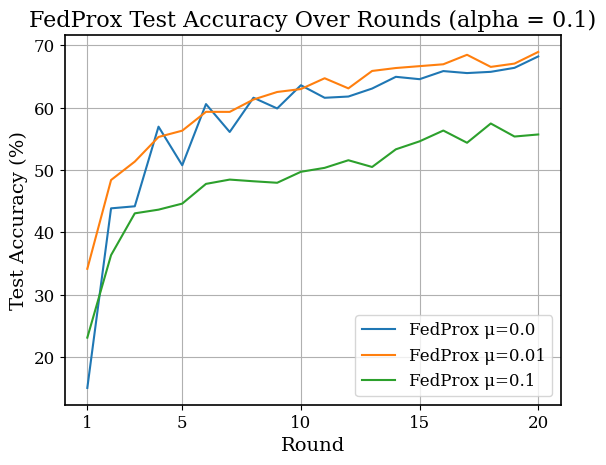

In [39]:
rounds = list(range(1, len(fedprox_mu0_a01_accs) + 1))
plt.plot(rounds, fedprox_mu0_a01_accs, label="FedProx μ=0.0")
plt.plot(rounds, fedprox_mu001_a01_accs, label="FedProx μ=0.01")
plt.plot(rounds, fedprox_mu01_a01_accs, label="FedProx μ=0.1")

plt.title("FedProx Test Accuracy Over Rounds (alpha = 0.1)")
plt.xlabel("Round")
plt.ylabel("Test Accuracy (%)")
plt.xticks([1, 5, 10, 15, 20])
plt.legend()
plt.grid(True)
plt.show()


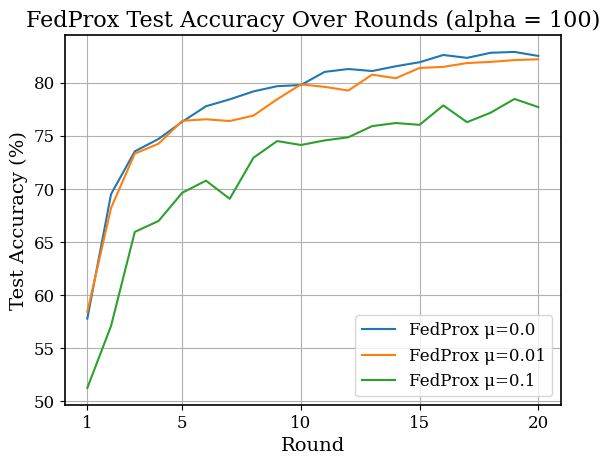

In [51]:
plt.plot(rounds, fedprox_mu0_a100_accs, label="FedProx μ=0.0")
plt.plot(rounds, fedprox_mu001_a100_accs, label="FedProx μ=0.01")
plt.plot(rounds, fedprox_mu01_a100_accs, label="FedProx μ=0.1")

plt.title("FedProx Test Accuracy Over Rounds (alpha = 100)")
plt.xlabel("Round")
plt.ylabel("Test Accuracy (%)")
plt.legend()
plt.xticks([1, 5, 10, 15, 20])
plt.grid(True)
plt.show()


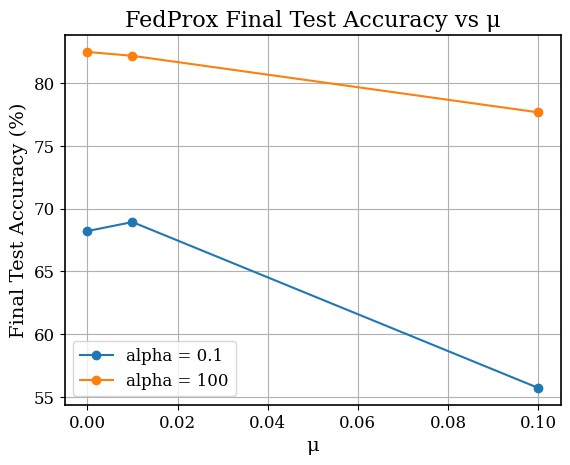

In [22]:
mus = [0.0, 0.01, 0.1]

final_a01 = [
    fedprox_mu0_a01_accs[-1],
    fedprox_mu001_a01_accs[-1],
    fedprox_mu01_a01_accs[-1],
]

final_a100 = [
    fedprox_mu0_a100_accs[-1],
    fedprox_mu001_a100_accs[-1],
    fedprox_mu01_a100_accs[-1],
]

plt.plot(mus, final_a01, marker="o", label="alpha = 0.1")
plt.plot(mus, final_a100, marker="o", label="alpha = 100")

plt.title("FedProx Final Test Accuracy vs μ")
plt.xlabel("μ")
plt.ylabel("Final Test Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()


## SCAFFOLD

In [52]:
# SCAFFOLD alpha=0.1
global_model_scaffold_a01, scaffold_a01_accs = fedavg_train(
    base_model=SmallCNN().to(device),
    train_dataset=train_set,
    test_loader=test_loader,
    algorithm="SCAFFOLD",
    alpha=0.1
)

train_loss, train_acc = evaluate(global_model_scaffold_a01, train_loader)
test_loss, test_acc = evaluate(global_model_scaffold_a01, test_loader)

print("SCAFFOLD | alpha=0.1")
print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


Client 0: [8.6% 0.8% 29.3% 0.0% 0.0% 0.2% 57.6% 0.0% 0.0% 3.5%]
Client 1: [0.0% 24.0% 16.9% 22.7% 0.0% 0.3% 0.0% 5.3% 0.5% 30.2%]
Client 2: [8.3% 0.1% 0.0% 0.0% 27.5% 0.0% 2.1% 28.5% 33.6%]
Client 3: [45.7% 17.7% 0.0% 21.7% 14.3% 0.0% 0.2% 0.1% 0.0% 0.3%]
Client 4: [0.1% 0.0% 0.0% 0.0% 0.2% 99.6%]
--- SCAFFOLD Round 1/20 --- Global Model | Train Acc: 32.99% | Test Acc: 34.14% | Time: 70.23 seconds
--- SCAFFOLD Round 2/20 --- Global Model | Train Acc: 45.08% | Test Acc: 45.83% | Time: 70.23 seconds
--- SCAFFOLD Round 3/20 --- Global Model | Train Acc: 50.35% | Test Acc: 52.18% | Time: 70.14 seconds
--- SCAFFOLD Round 4/20 --- Global Model | Train Acc: 55.05% | Test Acc: 57.29% | Time: 68.84 seconds
--- SCAFFOLD Round 5/20 --- Global Model | Train Acc: 56.32% | Test Acc: 58.23% | Time: 68.36 seconds
--- SCAFFOLD Round 6/20 --- Global Model | Train Acc: 58.27% | Test Acc: 60.63% | Time: 68.51 seconds
--- SCAFFOLD Round 7/20 --- Global Model | Train Acc: 60.36% | Test Acc: 63.05% | Time: 6

In [53]:
# SCAFFOLD alpha=100
global_model_scaffold_a100, scaffold_a100_accs = fedavg_train(
    base_model=SmallCNN().to(device),
    train_dataset=train_set,
    test_loader=test_loader,
    algorithm="SCAFFOLD",
    alpha=100
)

train_loss, train_acc = evaluate(global_model_scaffold_a100, train_loader)
test_loss, test_acc = evaluate(global_model_scaffold_a100, test_loader)

print("SCAFFOLD | alpha=100")
print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


Client 0: [10.7% 10.2% 10.3% 8.9% 10.3% 10.5% 10.9% 9.3% 8.9% 10.0%]
Client 1: [9.9% 11.0% 8.9% 10.7% 10.3% 8.7% 9.7% 10.9% 9.5% 10.5%]
Client 2: [10.0% 8.5% 9.8% 10.4% 11.1% 10.2% 9.0% 9.5% 11.2% 10.4%]
Client 3: [9.1% 10.6% 10.0% 10.6% 9.3% 9.2% 11.2% 10.0% 10.5% 9.5%]
Client 4: [10.3% 9.7% 10.9% 9.5% 9.1% 11.5% 9.1% 10.3% 9.9% 9.6%]
--- SCAFFOLD Round 1/20 --- Global Model | Train Acc: 49.87% | Test Acc: 52.29% | Time: 70.67 seconds
--- SCAFFOLD Round 2/20 --- Global Model | Train Acc: 54.88% | Test Acc: 59.48% | Time: 71.05 seconds
--- SCAFFOLD Round 3/20 --- Global Model | Train Acc: 53.10% | Test Acc: 55.82% | Time: 70.05 seconds
--- SCAFFOLD Round 4/20 --- Global Model | Train Acc: 59.76% | Test Acc: 62.94% | Time: 70.17 seconds
--- SCAFFOLD Round 5/20 --- Global Model | Train Acc: 65.41% | Test Acc: 67.93% | Time: 70.05 seconds
--- SCAFFOLD Round 6/20 --- Global Model | Train Acc: 64.45% | Test Acc: 66.25% | Time: 70.08 seconds
--- SCAFFOLD Round 7/20 --- Global Model | Train A

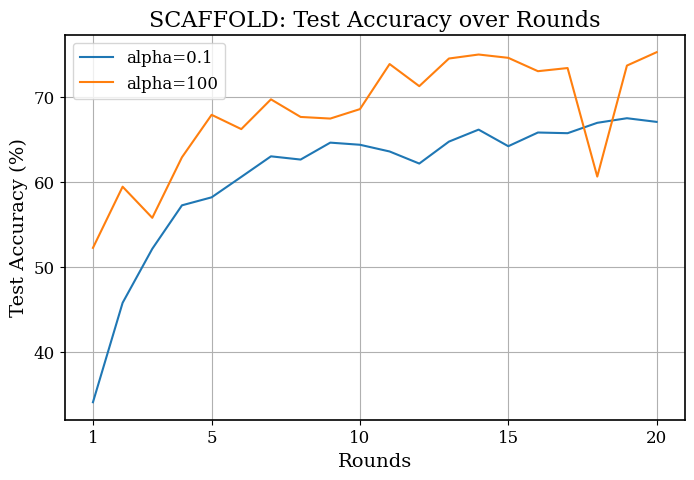

In [54]:
plt.figure(figsize=(8,5))
plt.plot(rounds, scaffold_a01_accs, label="alpha=0.1")
plt.plot(rounds, scaffold_a100_accs, label="alpha=100")
plt.xlabel("Rounds")
plt.ylabel("Test Accuracy (%)")
plt.title("SCAFFOLD: Test Accuracy over Rounds")
plt.xticks([1, 5, 10, 15, 20])
plt.legend()
plt.grid(True)
plt.show()

## FedGH

In [24]:
# FedGH alpha=0.1
global_model_fedgh_a01, fedgh_a01_accs = fedavg_train(
    base_model=SmallCNN().to(device),
    train_dataset=train_set,
    test_loader=test_loader,
    algorithm="FedGH",
    alpha=0.1
)

train_loss, train_acc = evaluate(global_model_fedgh_a01, train_loader)
test_loss, test_acc = evaluate(global_model_fedgh_a01, test_loader)

print("FedGH | alpha=0.1")
print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


Client 0: [0.0% 0.1% 70.0% 0.5% 0.9% 0.2% 0.0% 14.1% 0.0% 14.0%]
Client 1: [26.8% 3.1% 0.0% 1.0% 21.6% 0.0% 0.0% 16.6% 30.8% 0.1%]
Client 2: [0.0% 13.1% 0.4% 45.6% 19.2% 8.5% 8.8% 0.0% 0.0% 4.4%]
Client 3: [4.4% 0.0% 0.0% 7.0% 0.0% 36.9% 20.5% 0.0% 0.0% 31.1%]
Client 4: [1.9% 46.9% 0.0% 7.7% 0.0% 0.0% 25.8% 17.5% 0.2%]
--- FedGH Round 1/20 --- Global Model | Train Acc: 15.75% | Test Acc: 16.57% | Time: 69.07 seconds
--- FedGH Round 2/20 --- Global Model | Train Acc: 40.24% | Test Acc: 42.59% | Time: 69.29 seconds
--- FedGH Round 3/20 --- Global Model | Train Acc: 42.66% | Test Acc: 42.23% | Time: 69.63 seconds
--- FedGH Round 4/20 --- Global Model | Train Acc: 50.53% | Test Acc: 51.14% | Time: 68.78 seconds
--- FedGH Round 5/20 --- Global Model | Train Acc: 56.48% | Test Acc: 57.26% | Time: 68.83 seconds
--- FedGH Round 6/20 --- Global Model | Train Acc: 59.71% | Test Acc: 60.09% | Time: 68.97 seconds
--- FedGH Round 7/20 --- Global Model | Train Acc: 61.65% | Test Acc: 62.05% | Time: 

In [25]:
# FedGH alpha=100
global_model_fedgh_a100, fedgh_a100_accs = fedavg_train(
    base_model=SmallCNN().to(device),
    train_dataset=train_set,
    test_loader=test_loader,
    algorithm="FedGH",
    alpha=100
)

train_loss, train_acc = evaluate(global_model_fedgh_a100, train_loader)
test_loss, test_acc = evaluate(global_model_fedgh_a100, test_loader)

print("FedGH | alpha=100")
print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


Client 0: [10.7% 9.3% 9.4% 11.1% 9.8% 8.7% 10.3% 11.5% 8.8% 10.4%]
Client 1: [10.6% 10.7% 8.8% 12.1% 8.2% 10.5% 10.3% 8.4% 9.3% 11.0%]
Client 2: [8.5% 10.0% 11.4% 10.0% 9.6% 10.4% 10.3% 9.3% 11.2% 9.3%]
Client 3: [10.0% 8.7% 9.9% 8.2% 12.4% 11.0% 9.7% 10.9% 9.4% 9.8%]
Client 4: [10.1% 11.3% 10.5% 8.5% 10.0% 9.5% 9.5% 9.8% 11.4% 9.4%]
--- FedGH Round 1/20 --- Global Model | Train Acc: 52.80% | Test Acc: 55.54% | Time: 69.88 seconds
--- FedGH Round 2/20 --- Global Model | Train Acc: 67.72% | Test Acc: 70.23% | Time: 69.34 seconds
--- FedGH Round 3/20 --- Global Model | Train Acc: 70.76% | Test Acc: 72.97% | Time: 69.37 seconds
--- FedGH Round 4/20 --- Global Model | Train Acc: 74.82% | Test Acc: 75.98% | Time: 69.83 seconds
--- FedGH Round 5/20 --- Global Model | Train Acc: 75.60% | Test Acc: 77.16% | Time: 69.68 seconds
--- FedGH Round 6/20 --- Global Model | Train Acc: 77.38% | Test Acc: 78.06% | Time: 71.52 seconds
--- FedGH Round 7/20 --- Global Model | Train Acc: 78.32% | Test Acc: 

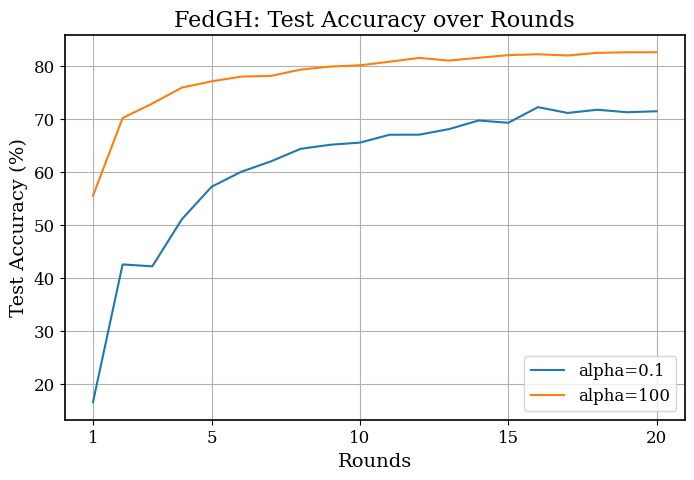

In [41]:
plt.figure(figsize=(8,5))
plt.plot(rounds, fedgh_a01_accs, label="alpha=0.1")
plt.plot(rounds, fedgh_a100_accs, label="alpha=100")
plt.xlabel("Rounds")
plt.ylabel("Test Accuracy (%)")
plt.title("FedGH: Test Accuracy over Rounds")
plt.xticks([1, 5, 10, 15, 20])
plt.legend()
plt.grid(True)
plt.show()


## FedSAM

In [55]:
# FedSAM alpha=0.1
global_model_fedsam_a01, fedsam_a01_accs = fedavg_train(
    base_model=SmallCNN().to(device),
    train_dataset=train_set,
    test_loader=test_loader,
    algorithm="FedSAM",
    alpha=0.1
)

train_loss, train_acc = evaluate(global_model_fedsam_a01, train_loader)
test_loss, test_acc = evaluate(global_model_fedsam_a01, test_loader)

print("FedSAM | alpha=0.1")
print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


Client 0: [0.0% 8.5% 18.1% 21.8% 4.3% 23.0% 23.8% 0.0% 0.3% 0.0%]
Client 1: [0.0% 0.0% 0.1% 4.8% 94.9% 0.0% 0.0% 0.0% 0.0% 0.2%]
Client 2: [0.0% 0.0% 1.2% 0.7% 0.0% 0.0% 0.0% 96.5% 0.7% 0.8%]
Client 3: [0.0% 0.0% 16.8% 4.9% 0.0% 4.9% 0.2% 0.0% 66.2% 7.0%]
Client 4: [38.5% 25.3% 0.4% 0.0% 0.0% 0.0% 1.4% 0.2% 0.1% 34.2%]
--- FedSAM Round 1/20 --- Global Model | Train Acc: 15.71% | Test Acc: 14.18% | Time: 73.24 seconds
--- FedSAM Round 2/20 --- Global Model | Train Acc: 36.87% | Test Acc: 37.72% | Time: 73.13 seconds
--- FedSAM Round 3/20 --- Global Model | Train Acc: 41.42% | Test Acc: 42.27% | Time: 73.07 seconds
--- FedSAM Round 4/20 --- Global Model | Train Acc: 47.67% | Test Acc: 47.86% | Time: 72.87 seconds
--- FedSAM Round 5/20 --- Global Model | Train Acc: 50.01% | Test Acc: 50.52% | Time: 72.95 seconds
--- FedSAM Round 6/20 --- Global Model | Train Acc: 52.87% | Test Acc: 53.21% | Time: 72.95 seconds
--- FedSAM Round 7/20 --- Global Model | Train Acc: 54.30% | Test Acc: 54.87% |

In [66]:
# FedSAM alpha=100
global_model_fedsam_a100, fedsam_a100_accs = fedavg_train(
    base_model=SmallCNN().to(device),
    train_dataset=train_set,
    test_loader=test_loader,
    algorithm="FedSAM",
    alpha=100
)

train_loss, train_acc = evaluate(global_model_fedsam_a100, train_loader)
test_loss, test_acc = evaluate(global_model_fedsam_a100, test_loader)

print("FedSAM | alpha=100")
print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


Client 0: [9.1% 10.3% 9.9% 10.6% 9.5% 9.6% 10.7% 10.4% 9.5% 10.6%]
Client 1: [9.4% 9.7% 10.3% 9.5% 10.7% 12.5% 8.2% 9.5% 9.3% 11.0%]
Client 2: [11.0% 9.9% 9.1% 11.3% 11.4% 8.5% 9.9% 9.6% 10.9% 8.4%]
Client 3: [10.6% 10.0% 12.0% 7.9% 10.0% 9.4% 9.9% 11.2% 10.2% 8.8%]
Client 4: [10.1% 10.1% 8.6% 10.7% 8.5% 10.0% 11.2% 9.3% 10.2% 11.2%]
--- FedSAM Round 1/20 --- Global Model | Train Acc: 48.32% | Test Acc: 49.20% | Time: 75.56 seconds
--- FedSAM Round 2/20 --- Global Model | Train Acc: 61.77% | Test Acc: 64.02% | Time: 75.38 seconds
--- FedSAM Round 3/20 --- Global Model | Train Acc: 67.09% | Test Acc: 69.12% | Time: 74.95 seconds
--- FedSAM Round 4/20 --- Global Model | Train Acc: 70.39% | Test Acc: 72.12% | Time: 74.66 seconds
--- FedSAM Round 5/20 --- Global Model | Train Acc: 72.35% | Test Acc: 73.84% | Time: 74.85 seconds
--- FedSAM Round 6/20 --- Global Model | Train Acc: 74.24% | Test Acc: 75.28% | Time: 75.00 seconds
--- FedSAM Round 7/20 --- Global Model | Train Acc: 75.75% | Tes

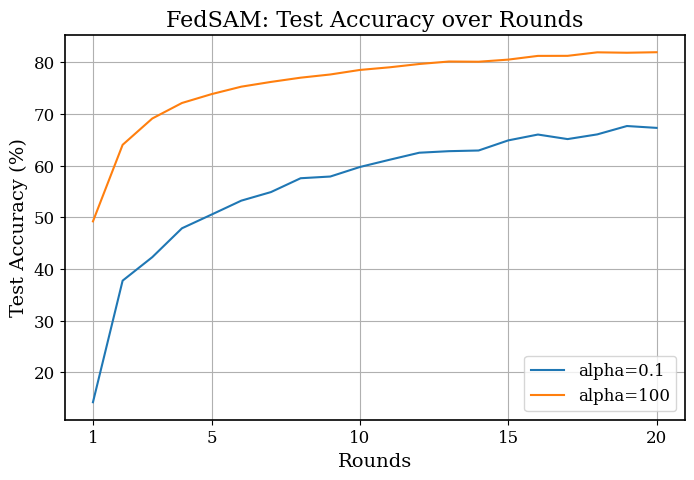

In [67]:
plt.figure(figsize=(8,5))
plt.plot(rounds, fedsam_a01_accs, label="alpha=0.1")
plt.plot(rounds, fedsam_a100_accs, label="alpha=100")
plt.xlabel("Rounds")
plt.ylabel("Test Accuracy (%)")
plt.title("FedSAM: Test Accuracy over Rounds")
plt.xticks([1, 5, 10, 15, 20])
plt.legend()
plt.grid(True)
plt.show()


## FedAvg Baseline

In [68]:
# ----------------------------
# FedAvg alpha=0.1
# ----------------------------
global_model_fedavg_a01, fedavg_a01_accs = fedavg_train(
    base_model=SmallCNN().to(device),
    train_dataset=train_set,
    test_loader=test_loader,
    algorithm="FedAvg",
    alpha=0.1
)

train_loss, train_acc = evaluate(global_model_fedavg_a01, train_loader)
test_loss, test_acc = evaluate(global_model_fedavg_a01, test_loader)

print("FedAvg | alpha=0.1")
print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


Client 0: [0.0% 0.0% 13.4% 37.4% 0.0% 0.0% 11.5% 0.0% 0.1% 37.4%]
Client 1: [22.6% 23.0% 0.2% 0.0% 0.0% 13.2% 0.0% 18.7% 22.3%]
Client 2: [1.1% 0.0% 0.0% 0.0% 58.9% 26.6% 0.0% 13.0% 0.4%]
Client 3: [2.4% 2.9% 67.5% 0.0% 0.0% 4.5% 16.8% 0.1% 5.8%]
Client 4: [1.7% 1.1% 0.1% 0.2% 15.8% 0.0% 78.3% 2.6% 0.0% 0.2%]
--- FedAvg Round 1/20 --- Global Model | Train Acc: 30.43% | Test Acc: 30.74% | Time: 74.16 seconds
--- FedAvg Round 2/20 --- Global Model | Train Acc: 41.05% | Test Acc: 41.80% | Time: 73.66 seconds
--- FedAvg Round 3/20 --- Global Model | Train Acc: 49.70% | Test Acc: 50.32% | Time: 74.23 seconds
--- FedAvg Round 4/20 --- Global Model | Train Acc: 50.56% | Test Acc: 52.05% | Time: 71.48 seconds
--- FedAvg Round 5/20 --- Global Model | Train Acc: 55.69% | Test Acc: 56.28% | Time: 70.97 seconds
--- FedAvg Round 6/20 --- Global Model | Train Acc: 58.94% | Test Acc: 59.27% | Time: 73.51 seconds
--- FedAvg Round 7/20 --- Global Model | Train Acc: 58.26% | Test Acc: 58.62% | Time: 73.

In [69]:
# ----------------------------
# FedAvg alpha=100
# ----------------------------
global_model_fedavg_a100, fedavg_a100_accs = fedavg_train(
    base_model=SmallCNN().to(device),
    train_dataset=train_set,
    test_loader=test_loader,
    algorithm="FedAvg",
    alpha=100
)

train_loss, train_acc = evaluate(global_model_fedavg_a100, train_loader)
test_loss, test_acc = evaluate(global_model_fedavg_a100, test_loader)

print("FedAvg | alpha=100")
print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


Client 0: [9.5% 10.8% 9.9% 9.7% 11.0% 9.8% 8.4% 10.5% 9.8% 10.5%]
Client 1: [9.2% 8.3% 10.4% 10.3% 10.6% 9.6% 10.8% 9.1% 11.0% 10.7%]
Client 2: [10.9% 9.4% 9.2% 9.5% 8.8% 10.7% 10.4% 11.0% 9.9% 10.2%]
Client 3: [10.3% 11.0% 8.9% 10.9% 9.5% 9.2% 9.9% 11.0% 10.8% 8.4%]
Client 4: [10.0% 10.5% 11.7% 9.5% 10.0% 10.9% 10.4% 8.3% 8.4% 10.3%]
--- FedAvg Round 1/20 --- Global Model | Train Acc: 58.21% | Test Acc: 61.90% | Time: 73.75 seconds
--- FedAvg Round 2/20 --- Global Model | Train Acc: 68.08% | Test Acc: 70.66% | Time: 74.09 seconds
--- FedAvg Round 3/20 --- Global Model | Train Acc: 71.00% | Test Acc: 73.50% | Time: 73.95 seconds
--- FedAvg Round 4/20 --- Global Model | Train Acc: 74.77% | Test Acc: 76.13% | Time: 73.21 seconds
--- FedAvg Round 5/20 --- Global Model | Train Acc: 75.61% | Test Acc: 76.39% | Time: 73.94 seconds
--- FedAvg Round 6/20 --- Global Model | Train Acc: 77.72% | Test Acc: 78.16% | Time: 75.11 seconds
--- FedAvg Round 7/20 --- Global Model | Train Acc: 78.60% | Te

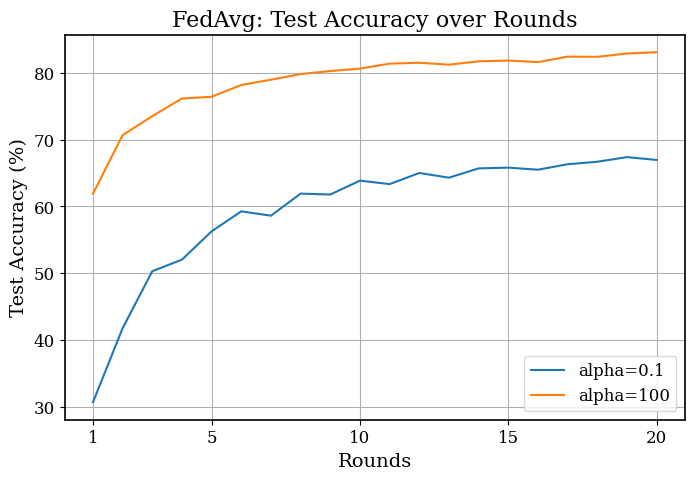

In [70]:

plt.figure(figsize=(8,5))
plt.plot(rounds, fedavg_a01_accs, label="alpha=0.1")
plt.plot(rounds, fedavg_a100_accs, label="alpha=100")
plt.xlabel("Rounds")
plt.ylabel("Test Accuracy (%)")
plt.xticks([1, 5, 10, 15, 20])
plt.title("FedAvg: Test Accuracy over Rounds")
plt.legend()
plt.grid(True)
plt.show()


## Final

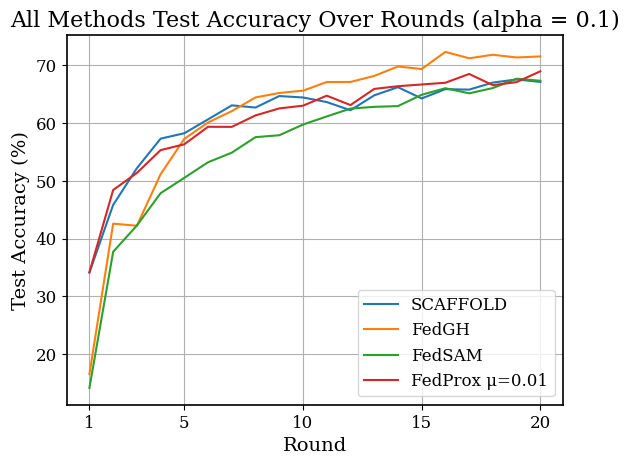

In [71]:
plt.plot(rounds, scaffold_a01_accs, label="SCAFFOLD")
plt.plot(rounds, fedgh_a01_accs, label="FedGH")
plt.plot(rounds, fedsam_a01_accs, label="FedSAM")
plt.plot(rounds, fedprox_mu001_a01_accs, label="FedProx μ=0.01")

plt.title("All Methods Test Accuracy Over Rounds (alpha = 0.1)")
plt.xlabel("Round")
plt.xticks([1, 5, 10, 15, 20])
plt.ylabel("Test Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()


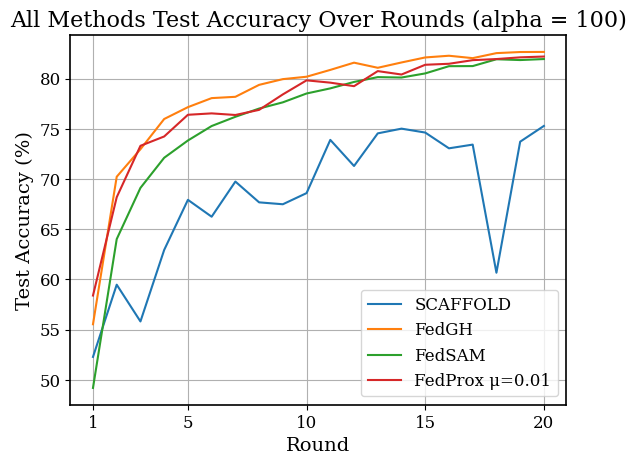

In [72]:
plt.plot(rounds, scaffold_a100_accs, label="SCAFFOLD")
plt.plot(rounds, fedgh_a100_accs, label="FedGH")
plt.plot(rounds, fedsam_a100_accs, label="FedSAM")
plt.plot(rounds, fedprox_mu001_a100_accs, label="FedProx μ=0.01")

plt.title("All Methods Test Accuracy Over Rounds (alpha = 100)")
plt.xlabel("Round")
plt.ylabel("Test Accuracy (%)")
plt.xticks([1, 5, 10, 15, 20])
plt.legend()
plt.grid(True)
plt.show()

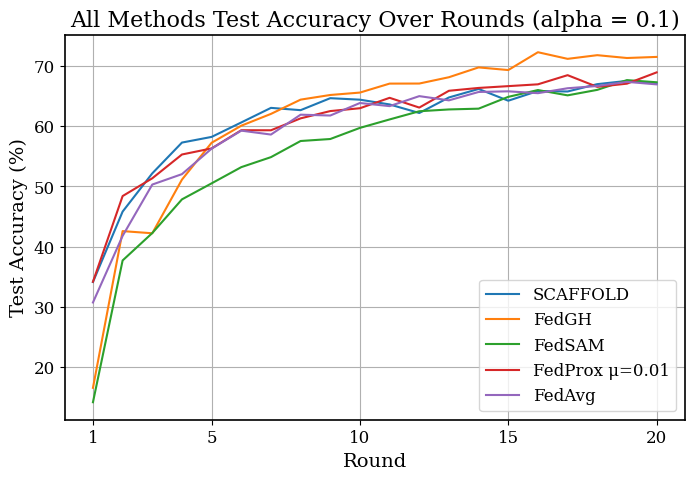

In [73]:
plt.figure(figsize=(8,5))
plt.plot(rounds, scaffold_a01_accs, label="SCAFFOLD")
plt.plot(rounds, fedgh_a01_accs, label="FedGH")
plt.plot(rounds, fedsam_a01_accs, label="FedSAM")
plt.plot(rounds, fedprox_mu001_a01_accs, label="FedProx μ=0.01")
plt.plot(rounds, fedavg_a01_accs, label="FedAvg")

plt.title("All Methods Test Accuracy Over Rounds (alpha = 0.1)")
plt.xlabel("Round")
plt.ylabel("Test Accuracy (%)")
plt.xticks([1, 5, 10, 15, 20])
plt.legend()
plt.grid(True)
plt.show()


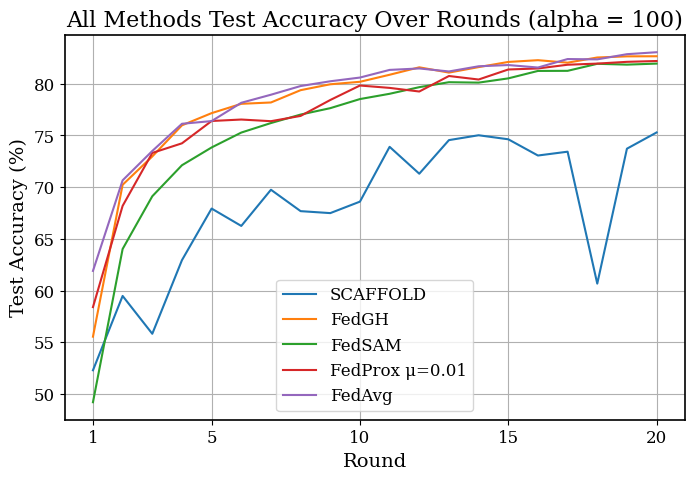

In [74]:
plt.figure(figsize=(8,5))
plt.plot(rounds, scaffold_a100_accs, label="SCAFFOLD")
plt.plot(rounds, fedgh_a100_accs, label="FedGH")
plt.plot(rounds, fedsam_a100_accs, label="FedSAM")
plt.plot(rounds, fedprox_mu001_a100_accs, label="FedProx μ=0.01")
plt.plot(rounds, fedavg_a100_accs, label="FedAvg")

plt.title("All Methods Test Accuracy Over Rounds (alpha = 100)")
plt.xlabel("Round")
plt.ylabel("Test Accuracy (%)")
plt.xticks([1, 5, 10, 15, 20])
plt.legend()
plt.grid(True)
plt.show()


## Recovery

In [75]:
torch.save(global_model_fedprox_mu0_a01.state_dict(), "fedprox_mu0_a01.pt")
torch.save(global_model_fedprox_mu0_a100.state_dict(), "fedprox_mu0_a100.pt")

torch.save(global_model_fedprox_mu001_a01.state_dict(), "fedprox_mu001_a01.pt")
torch.save(global_model_fedprox_mu001_a100.state_dict(), "fedprox_mu001_a100.pt")

torch.save(global_model_fedprox_mu01_a01.state_dict(), "fedprox_mu01_a01.pt")
torch.save(global_model_fedprox_mu01_a100.state_dict(), "fedprox_mu01_a100.pt")

torch.save(global_model_scaffold_a01.state_dict(), "scaffold_a01.pt")
torch.save(global_model_scaffold_a100.state_dict(), "scaffold_a100.pt")

torch.save(global_model_fedgh_a01.state_dict(), "fedgh_a01.pt")
torch.save(global_model_fedgh_a100.state_dict(), "fedgh_a100.pt")

torch.save(global_model_fedsam_a01.state_dict(), "fedsam_a01.pt")
torch.save(global_model_fedsam_a100.state_dict(), "fedsam_a100.pt")

print("All models saved successfully.")

All models saved successfully.


In [ ]:

# global_model_fedprox_mu0_a01 = SmallCNN().to(device)
# global_model_fedprox_mu0_a01.load_state_dict(torch.load("fedprox_mu0_a01.pt"))

# global_model_fedprox_mu0_a100 = SmallCNN().to(device)
# global_model_fedprox_mu0_a100.load_state_dict(torch.load("fedprox_mu0_a100.pt"))

# global_model_fedprox_mu001_a01 = SmallCNN().to(device)
# global_model_fedprox_mu001_a01.load_state_dict(torch.load("fedprox_mu001_a01.pt"))

# global_model_fedprox_mu001_a100 = SmallCNN().to(device)
# global_model_fedprox_mu001_a100.load_state_dict(torch.load("fedprox_mu001_a100.pt"))

# global_model_fedprox_mu01_a01 = SmallCNN().to(device)
# global_model_fedprox_mu01_a01.load_state_dict(torch.load("fedprox_mu01_a01.pt"))

# global_model_fedprox_mu01_a100 = SmallCNN().to(device)
# global_model_fedprox_mu01_a100.load_state_dict(torch.load("fedprox_mu01_a100.pt"))

# global_model_scaffold_a01 = SmallCNN().to(device)
# global_model_scaffold_a01.load_state_dict(torch.load("scaffold_a01.pt"))

# global_model_scaffold_a100 = SmallCNN().to(device)
# global_model_scaffold_a100.load_state_dict(torch.load("scaffold_a100.pt"))

# global_model_fedgh_a01 = SmallCNN().to(device)
# global_model_fedgh_a01.load_state_dict(torch.load("fedgh_a01.pt"))

# global_model_fedgh_a100 = SmallCNN().to(device)
# global_model_fedgh_a100.load_state_dict(torch.load("fedgh_a100.pt"))

# global_model_fedsam_a01 = SmallCNN().to(device)
# global_model_fedsam_a01.load_state_dict(torch.load("fedsam_a01.pt"))

# global_model_fedsam_a100 = SmallCNN().to(device)
# global_model_fedsam_a100.load_state_dict(torch.load("fedsam_a100.pt"))

# print("All models loaded back successfully.")